In [187]:
from funcs import *

In [245]:
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [3]:
df = wrangle("train.csv")
df

,id,plate,date,price,year,month,day_week,letters,numbers,region,dept_name,forb_buy,adv_road,significance
0,1,X059CP797,2024-12-26 00:00:00,65000,2024,december,thursday,XCP,059,Москва,not governmental,0,0,0
1,2,Y800MH790,2024-07-12 21:31:37,100000,2024,july,friday,YMH,800,Московская область,not governmental,0,0,0
2,3,A212TX77,2024-04-18 00:00:00,290000,2024,april,thursday,ATX,212,Москва,not governmental,0,0,0
3,4,P001AY199,2025-01-03 00:27:15,680000,2025,january,friday,PAY,001,Москва,not governmental,0,0,0
4,5,P001AY199,2025-01-10 09:32:41,750000,2025,january,friday,PAY,001,Москва,not governmental,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51630,51631,X023PP797,2025-01-29 00:00:00,70000,2025,january,wednesday,XPP,023,Москва,not governmental,0,0,0
51631,51632,M004KA161,2025-01-31 00:00:00,1600000,2025,january,friday,MKA,004,Ростовская область,not governmental,0,0,0
51632,51633,E888EB199,2025-02-06 00:00:00,850000,2025,february,thursday,EEB,888,Москва,not governmental,0,0,0
51633,51634,X023XK77,2024-04-24 11:30:07,150000,2024,april,wednesday,XXK,023,Москва,not governmental,0,0,0


In [253]:
X = df.drop(["id", "plate", "date", "dept_name", "price"], axis=1)
X

,year,month,day_week,letters,numbers,region,forb_buy,adv_road,significance
0,2024,december,thursday,XCP,059,Москва,0,0,0
1,2024,july,friday,YMH,800,Московская область,0,0,0
2,2024,april,thursday,ATX,212,Москва,0,0,0
3,2025,january,friday,PAY,001,Москва,0,0,0
4,2025,january,friday,PAY,001,Москва,0,0,0
...,...,...,...,...,...,...,...,...,...
51630,2025,january,wednesday,XPP,023,Москва,0,0,0
51631,2025,january,friday,MKA,004,Ростовская область,0,0,0
51632,2025,february,thursday,EEB,888,Москва,0,0,0
51633,2024,april,wednesday,XXK,023,Москва,0,0,0


In [254]:
ct = ColumnTransformer([
    ("ohe", OneHotEncoder(), ["year", "month", "day_week", "letters", "numbers", "region"]),
    ("ss", StandardScaler(), make_column_selector(dtype_include=np.number))
],
    remainder="passthrough"
)

X = ct.fit_transform(X).toarray()
X

array([[ 0.        ,  0.        ,  0.        , ..., -0.00762257,
        -0.10824504, -0.10289599],
       [ 0.        ,  0.        ,  0.        , ..., -0.00762257,
        -0.10824504, -0.10289599],
       [ 0.        ,  0.        ,  0.        , ..., -0.00762257,
        -0.10824504, -0.10289599],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.00762257,
        -0.10824504, -0.10289599],
       [ 0.        ,  0.        ,  0.        , ..., -0.00762257,
        -0.10824504, -0.10289599],
       [ 0.        ,  0.        ,  1.        , ..., -0.00762257,
        -0.10824504, -0.10289599]])

In [288]:
y = df["price"]
y

0          65000
1         100000
2         290000
3         680000
4         750000
          ...   
51630      70000
51631    1600000
51632     850000
51633     150000
51634      25000
Name: price, Length: 51635, dtype: int64

In [289]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2)

In [290]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
X_train.shape

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [291]:
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)
y_train.shape

torch.Size([41308])

In [172]:
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

In [10]:
torch.manual_seed(42)

In [173]:
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=256, shuffle=False)
train_dl

In [57]:
device = "cpu"

In [215]:
model = nn.Sequential()
model.add_module(
    "ll1",
    nn.Linear(
        in_features=X_train.shape[1], out_features=700
    )
)
model.add_module("relu1", nn.ReLU())
model.add_module("dropout1", nn.Dropout(p=0.5))
model.add_module(
    "ll2",
    nn.Linear(
        in_features=700, out_features=700
    )
)
model.add_module("relu2", nn.ReLU())
model.add_module("dropout2", nn.Dropout(p=0.5))
model.add_module(
    "ll3",
    nn.Linear(
        in_features=700, out_features=1
    )
)
model.to(device)
model

Sequential(
  (ll1): Linear(in_features=2842, out_features=700, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (ll2): Linear(in_features=700, out_features=700, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (ll3): Linear(in_features=700, out_features=1, bias=True)
)

In [216]:
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

In [203]:
model.parameters

<bound method Module.parameters of Sequential(
  (ll1): Linear(in_features=2842, out_features=1400, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (ll2): Linear(in_features=1400, out_features=1400, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (ll3): Linear(in_features=1400, out_features=1, bias=True)
)>

In [217]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00003)

In [82]:
len(train_dl.dataset)

41308

In [218]:
def train(model, n_epochs, train_dl, val_dl):
    loss_hist_train = [0] * n_epochs
    loss_hist_val = [0] * n_epochs
    for epoch in range(n_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
        loss_hist_train[epoch] = loss_hist_train[epoch] / len(train_dl.dataset)
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_dl:
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch)
                loss_hist_val[epoch] = loss.item() * y_batch.size(0)
        loss_hist_val[epoch] = loss_hist_val[epoch] / len(val_dl.dataset)
        if epoch % 10 == 0:
                print(f"Epoch: {epoch}, Training loss: {loss_hist_train[epoch]}, Validation Loss: {loss_hist_val[epoch]}")
    return loss_hist_train, loss_hist_val                

In [219]:
n_epochs = 100
hist = train(model, n_epochs, train_dl, val_dl)

Epoch: 0, Training loss: 3517148506815.8203, Validation Loss: 1520886457.2758787
Epoch: 10, Training loss: 3513985452815.9395, Validation Loss: 1510108456.9768567
Epoch: 20, Training loss: 3499569292791.0264, Validation Loss: 1467408191.2377264
Epoch: 30, Training loss: 3471425454805.04, Validation Loss: 1391277573.701559
Epoch: 40, Training loss: 3430104646325.3096, Validation Loss: 1291265471.498015
Epoch: 50, Training loss: 3377394507086.6567, Validation Loss: 1185311155.6982667
Epoch: 60, Training loss: 3316521366883.8765, Validation Loss: 1100983510.4777768
Epoch: 70, Training loss: 3252493629360.4756, Validation Loss: 1070346279.2663891
Epoch: 80, Training loss: 3195361196008.004, Validation Loss: 1117823325.0345695
Epoch: 90, Training loss: 3145983222593.717, Validation Loss: 1246471331.510797


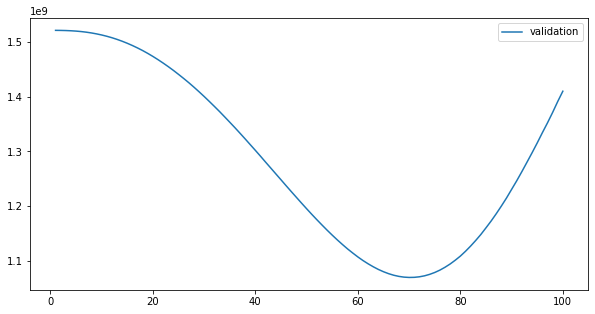

In [220]:
fig, ax = plt.subplots(figsize=(10, 5))
#ax.plot(range(1, n_epochs + 1), hist[0], label="train")
ax.plot(range(1, n_epochs + 1), hist[1], label="validation")
#ax.set_yscale('log')
ax.legend()

In [146]:
#model.eval()
pred = model(torch.tensor(X_val, dtype=torch.float32)).detach()
pred

C:\Users\User\AppData\Local\Temp\ipykernel_8620\1944200889.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model(torch.tensor(X_val, dtype=torch.float32)).detach()


tensor([[337429.0000],
        [231025.8438],
        [248251.2969],
        ...,
        [237181.5625],
        [842437.6250],
        [267870.4375]])

In [147]:
y_val.resize_(len(pred), 1)

tensor([[  35000.],
        [  65000.],
        [1200000.],
        ...,
        [  80000.],
        [ 250000.],
        [  80000.]])

In [197]:
from funcs import smape_torch

In [292]:
smape_torch(model, X_val, y_val)

185.4823455810547

In [199]:
def smape_torch(model, X, y):
    pred = model(torch.tensor(X, dtype=torch.float32))
    val = y.resize_(X.shape[0], 1).detach().clone()
    return (torch.sum(torch.abs(pred - val) / (torch.abs(val) + torch.abs(pred)) * 2) * 100 / len(pred)).item()

In [262]:
test = wrangle("test.csv")
test

,id,plate,date,price,year,month,day_week,letters,numbers,region,dept_name,forb_buy,adv_road,significance
0,51636,P700TT790,2025-01-27 00:00:00,NaN,2025,january,monday,PTT,700,Московская область,not governmental,0,0,0
1,51637,M081TX797,2025-02-10 00:00:00,NaN,2025,february,monday,MTX,081,Москва,not governmental,0,0,0
2,51638,T333HX777,2025-02-11 00:00:00,NaN,2025,february,tuesday,THX,333,Москва,not governmental,0,0,0
3,51639,H744BH977,2025-02-03 00:00:00,NaN,2025,february,monday,HBH,744,Москва,not governmental,0,0,0
4,51640,X066EM777,2025-02-12 00:00:00,NaN,2025,february,wednesday,XEM,066,Москва,not governmental,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7690,59326,X799CC799,2023-03-13 00:00:00,NaN,2023,march,monday,XCC,799,Москва,not governmental,0,0,0
7691,59327,K077YT777,2022-10-19 00:00:00,NaN,2022,october,wednesday,KYT,077,Москва,not governmental,0,0,0
7692,59328,O200PA777,2023-10-02 19:19:30,NaN,2023,october,monday,OPA,200,Москва,not governmental,0,0,0
7693,59329,O073OO97,2025-01-12 00:00:00,NaN,2025,january,sunday,OOO,073,Москва,not governmental,0,0,0


In [263]:
test = ct.transform(test.drop(["id", "plate", "date", "dept_name", "price"], axis=1)).toarray()
test = torch.tensor(test, dtype=torch.float32)
test

tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0076, -0.1082, -0.1029],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0076, -0.1082, -0.1029],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0076, -0.1082, -0.1029],
        ...,
        [ 0.0000,  0.0000,  1.0000,  ..., -0.0076, -0.1082, -0.1029],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0076, -0.1082, -0.1029],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0076, -0.1082, -0.1029]])

In [277]:
pd.DataFrame(
        {
            "ID": range(51636, 59331),
            "price": model(test).detach().numpy().squeeze()
        }
    ).to_csv("deep_neural_network.csv", index=False)

In [293]:
torch.save(model, "dnn.pt")

In [295]:
model = torch.load("dnn.pt", weights_only=False)
model.eval()

Sequential(
  (ll1): Linear(in_features=2842, out_features=700, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (ll2): Linear(in_features=700, out_features=700, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (ll3): Linear(in_features=700, out_features=1, bias=True)
)